In [1]:
# imports from Qiskit
from numpy import pi
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

In [2]:
# imports from backend providers (IBM for superconductor, AQT for trapped ion)
from qiskit.providers.ibmq import IBMQ
from qiskit.providers.aqt import AQT

ibmq_provider = IBMQ.load_account()        # credentials stored on disk
aqt_provider_simulators = AQT.enable_account('2633b2d14dae4d9da7c9df2503857334')  # simulator credentials
# aqt_provider_device = AQT.enable_account('INPUT DEVICE CREDENTIALS HERE') # hardware credentials

ibmq_simulator = ibmq_provider.get_backend('ibmq_qasm_simulator')
ibmq_device = ibmq_provider.get_backend('ibmq_burlington')
aqt_simulator = aqt_provider_simulators.get_backend('aqt_qasm_simulator')
# calling noisy simulator the 'device' for now
aqt_device = aqt_provider_simulators.get_backend('aqt_qasm_simulator_noise_1')

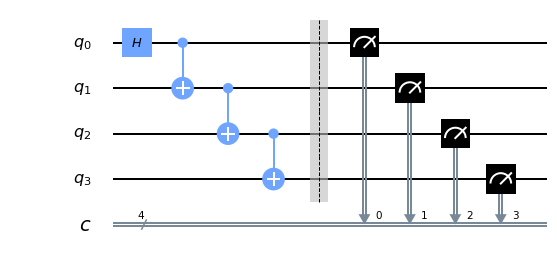

In [3]:
n = 4
qc = QuantumCircuit(n, n)
qc.h(0)
for i in range(0, n-1):
    qc.cx(i, i+1)
qc.barrier()
qc.measure(range(n), range(n))
qc.draw(output='mpl')

In [4]:
# display all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Backend in use:  aqt_qasm_simulator


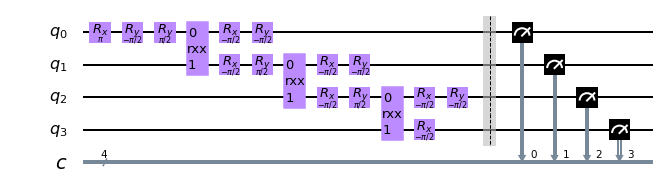

Done
Backend in use:  ibmq_qasm_simulator


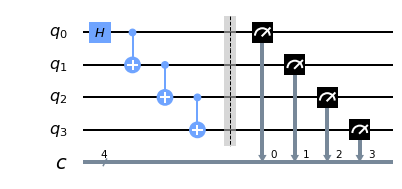

Done
Backend in use:  aqt_qasm_simulator_noise_1


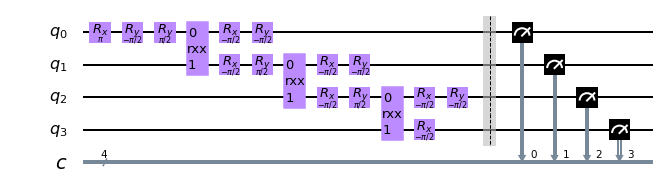

Done
Backend in use:  ibmq_burlington


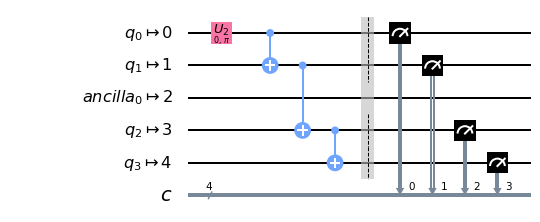

Job Status: job has successfully run
Done


In [5]:
# transpile, plot circuit, run, plot result
backends = [aqt_simulator, ibmq_simulator, aqt_device, ibmq_device]
for be in backends:
    print("Backend in use: ", be)
    new_qc = transpile(qc, be)
    new_qc.draw(output='mpl', scale=0.5)

    job = execute(new_qc, be, shots=200)
    if be == ibmq_device:
        job_monitor(job)
    counts = job.result().get_counts()
    plot_histogram(counts)
    print('Done')
    
    if be == aqt_simulator:
        aqt_sim_results = job.result()
        aqt_sim_counts = job.result().get_counts()
    if be == ibmq_simulator:
        ibmq_sim_results = job.result()
        ibmq_sim_counts = job.result().get_counts()
    if be == aqt_device:
        aqt_dev_results = job.result()
        aqt_dev_counts = job.result().get_counts()
    if be == ibmq_device:
        ibmq_dev_results = job.result()
        ibmq_dev_counts = job.result().get_counts()

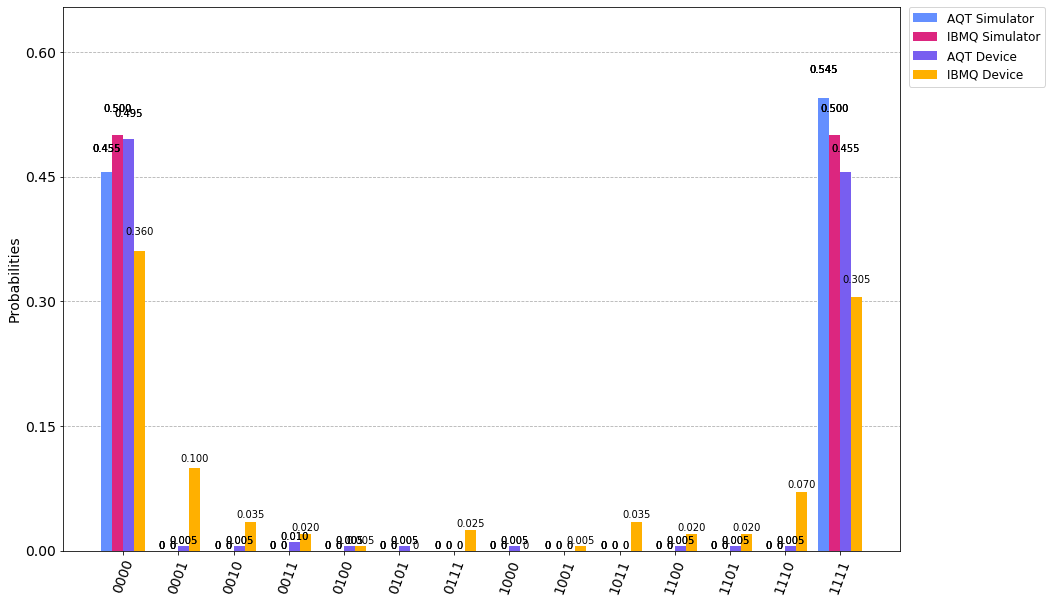

In [13]:
# plotting the results together
plot_histogram([aqt_sim_counts, ibmq_sim_counts, aqt_dev_counts, ibmq_dev_counts], 
               legend = ['AQT Simulator', 'IBMQ Simulator', 'AQT Device', 'IBMQ Device'],
               figsize = (15,10))

Job Status: job has successfully run


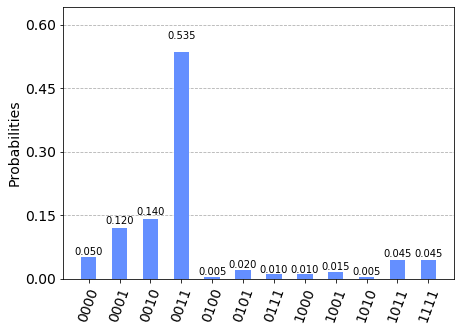

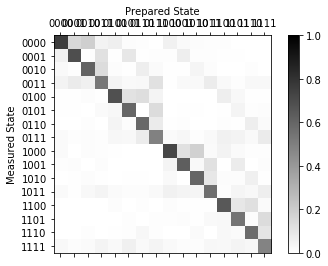

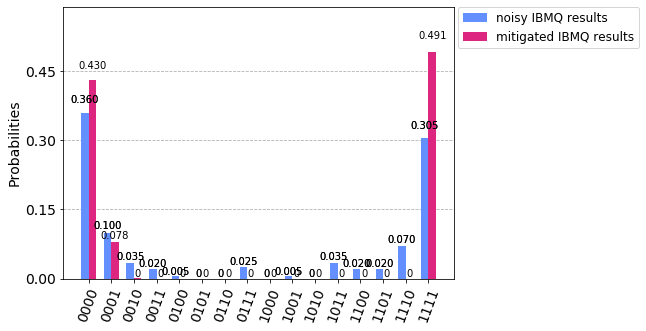

In [7]:
# can run noise mitigation at least for IBMQ right now, using Qiskit Ignis
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

# devices = [ibmq_device, aqt_device]
# for dev in devices:
# print('Device in use:', dev)
cal_circuits, state_labels = complete_meas_cal(qr = qc.qregs[0], circlabel = 'measerrormitcal')
cal_job = execute(cal_circuits,
                  backend = ibmq_device,
                  shots = 200,
                  optimization_level = 0)
job_monitor(cal_job)
calres = cal_job.result()

plot_histogram(calres.get_counts(cal_circuits[3]))

meas_fitter = CompleteMeasFitter(calres, state_labels)
meas_fitter.plot_calibration()

meas_filter = meas_fitter.filter
    
#     if dev == aqt_device:
#         mitres = meas_filter.apply(aqt_dev_counts)
#         mitcounts = mitres.get_counts(qc)
#         aqt_mit_counts = mitcounts

# if dev == ibmq_device:
mitres = meas_filter.apply(ibmq_dev_results)
mitcounts = mitres.get_counts(qc)
ibmq_mit_counts = mitcounts

plot_histogram([ibmq_dev_counts, ibmq_mit_counts], 
               legend = ['noisy IBMQ results', 'mitigated IBMQ results'],
               figsize = (15,10))
# plot_histogram([aqt_dev_counts, aqt_mit_counts], legend = ['noisy AQT results', 'mitigated AQT results'])

In [8]:
# restore display settings
InteractiveShell.ast_node_interactivity = "last_expr"

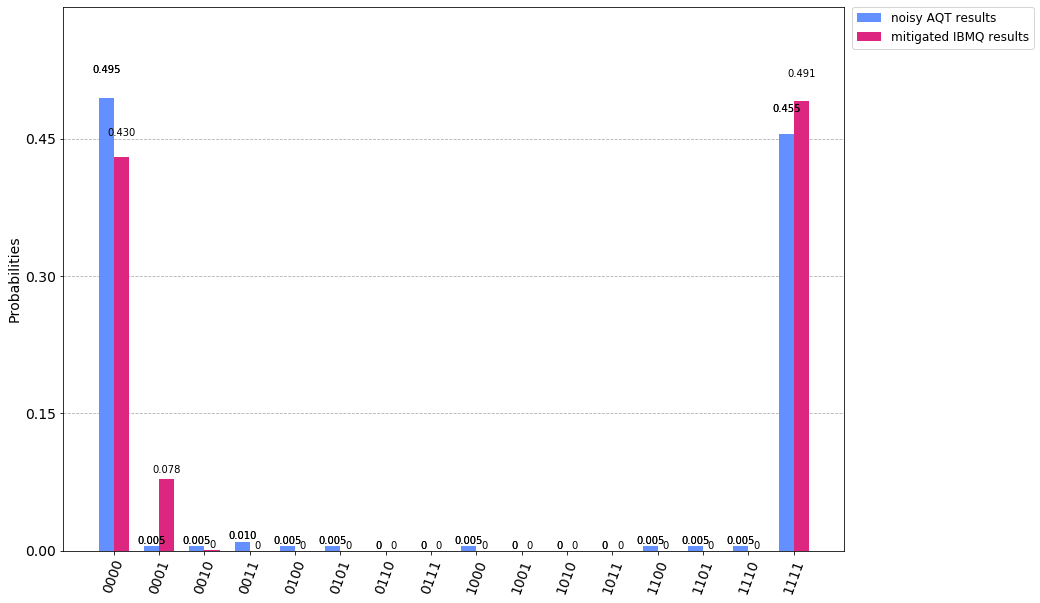

In [18]:
plot_histogram([aqt_dev_counts, ibmq_mit_counts], 
               legend = ['noisy AQT results', 'mitigated IBMQ results'], 
               figsize = (14,10))

In [10]:
import qiskit.tools.jupyter
%qiskit_version_table